# July 2024 Scenario 2* - Limiting Hospitalizations
*from ASKEM 6-month Hackathon Scenarios

### Scenario Background 
You are a disease modeler supporting the Los Angeles County Department of Public Health, at the beginning of the original Omicron wave. The LA County Board of Supervisors is concerned about what the next few months will look like, and what level of intervention will be required to manage what is shaping up to be a large winter Covid-19 wave. Vaccines were broadly available during this time period and vaccination should be accounted for in the modeling.

### Scenario Setting/Situation
Time = December 28th, 2021 (right around upswing of Omicron wave)

Location = LA County

### Load dependencies

In [1]:
import os
import json
import sympy
import torch
import numpy as np
import pandas as pd
from typing import Dict, List, Callable

# MIRA modeling dependencies
from mira.metamodel import *
from mira.metamodel.ops import stratify
from mira.examples.concepts import susceptible, exposed, infected, recovered
from mira.modeling import Model
from mira.modeling.amr.petrinet import AMRPetriNetModel, template_model_to_petrinet_json
from mira.sources.amr.petrinet import template_model_from_amr_json
from mira.metamodel.io import model_to_json_file, model_from_json_file

# PyCIEMSS dependencies
import pyciemss
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories
from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)

# Gather and process data

Date range: October 28, 2021 - December 28, 2021

Data source: Cumulative case and death data from New York Times [COVID-19 Data Github](https://github.com/nytimes/covid-19-data)

In [2]:
# Process data

# url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties-2021.csv"
# df = pd.read_csv(url)

# # Filter the data
# filtered_df = df[(df['county'] == "Los Angeles") & (df['state'] == "California")]

# # Convert date column to datetime
# filtered_df['date'] = pd.to_datetime(filtered_df['date'])

# # Print the row for 2021-10-23 to estimate Recovered population
# row_2021_10_23 = filtered_df[filtered_df['date'] == '2021-10-23']
# print("Row for 2021-10-23:")
# print(row_2021_10_23)

# # Sort the data by date
# sorted_df = filtered_df.sort_values(by='date')

# # Filter the data between the specified dates
# start_date = '2021-10-28'
# end_date = '2021-12-28'
# mask = (sorted_df['date'] >= start_date) & (sorted_df['date'] <= end_date)
# final_df = sorted_df.loc[mask]

# # Drop unwanted columns
# final_df.reset_index(drop=True, inplace=True)
# final_df.index.name = 'Timestamp'
# final_df = final_df[['cases', 'deaths']]

# # Display the final DataFrame
# # print(final_df)
# final_df.to_csv("LA_county_covid_data.csv", index=True)

# Select data

data = "LA_county_covid_data.csv"
# data_df = pd.read_csv(data)
# print(data_df.head())

### Set data for population and initial conditions

In [3]:
LA_county_total_pop = 9_830_000 # US Census Bureau
p_vacc = 0.72 # Percent vaccinated 10/28/2021, from California Health and Human Services Open Data Portal
initial_cumulative_cases = 1_490_084 # 10/28/2021, from NYT data
initial_deaths = 26_604 # 10/28/2021, from NYT data
initial_hosp = 586 + 87 # confirmed + suspected, 10/28/2021, from LA County COVID-19 Surveillance Dashboard
initial_recovered = 1_484_896 # Estimate of recovered population = cumulative cases 10/23/2021, from NYT data 
initial_cases = 1_490_084 - 1_484_896 # Estimate of active cases 10/28/2021, from NYT data
initial_exposed = 2*initial_cases # Estimate of exposed population 10/28/2021
initial_susceptible = LA_county_total_pop - (initial_deaths + initial_hosp + initial_recovered + initial_cases + initial_exposed)

# Build model with vaccinations and hospitalizations

### Define units

In [4]:
person_units = lambda: Unit(expression=sympy.Symbol('person'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))
per_day_per_person_units = lambda: Unit(expression=1/(sympy.Symbol('day')*sympy.Symbol('person')))

### Define and stratify model concepts

In [5]:
_susceptible = Concept(name='S', units=person_units(), identifiers={'ido': '0000514'})
_exposed = Concept(name='E', units=person_units(), identifiers={'apollosv': '00000154'})
_infected = Concept(name='I', units=person_units(), identifiers={'ido': '0000511'})

c = {
    'S_u': _susceptible.with_context(status="unvaccinated"),
    'S_v': _susceptible.with_context(status="vaccinated"),
    
    'E_u': _exposed.with_context(status="unvaccinated"),
    'E_v': _exposed.with_context(status="vaccinated"),
    
    'I_u': _infected.with_context(status="unvaccinated"),
    'I_v': _infected.with_context(status="vaccinated"),
    
    'R': Concept(name='R', units=person_units(), identifiers={'ido': '0000592'}),
    'H': Concept(name="H", units=person_units(), identifiers={"ido": "0000511"},
                        context={"property": "ncit:C25179"}),
    'D': Concept(name="D", units=person_units(), identifiers={"ncit": "C28554"}),
    
    "Cumulative_cases": Concept(name="Cumulative_cases", units=person_units()),
}

for concept in c:
    c[concept].name = concept

### Define parameters with uncertainty
Parameter values estimated from CDC COVID-19 Planning Scenarios data

In [6]:
parameters = {
    'beta': Parameter(name='beta', value=sympy.Float(0.1), units=per_day_units(),
                      distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.09,
                                                            'maximum': 0.11})),  # Transmission rate

    'NPI_mult': Parameter(name='NPI_mult', value=sympy.Float(1.0), units=dimensionless_units(),
                      distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.999,
                                                            'maximum': 1.001})),  # NPI (social distancing/masking) multiplier

    'vacc_mult': Parameter(name='vacc_mult', value=sympy.Float(0.5), units=dimensionless_units(),
                      distribution=None),  # Vaccination multiplier
    
    'N': Parameter(name='total_population', value=sympy.Float(LA_county_total_pop), units=person_units()),  # Total population
    
    'r_EI': Parameter(name='r_EI', value=sympy.Float(0.1424), units=per_day_units(),
                     distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.1,
                                                            'maximum': 0.25})),  # Rate of progressing E -> I
    
    'r_IR_u': Parameter(name='r_IR_u', value=sympy.Float(0.15), units=per_day_units(),
                     distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.1,
                                                            'maximum': 0.2})),  # Rate of progressing I_u -> R
    'r_IR_v': Parameter(name='r_IR_v', value=sympy.Float(0.162), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                            parameters={'minimum': 0.15,
                                                        'maximum': 0.2})),  # Rate of progressing I_v -> R

    'r_IH_u': Parameter(name='r_IH_u', value=sympy.Float(0.0051), units=per_day_units(),
                     distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.005,
                                                            'maximum': 0.0055})),  # Rate of progressing I_u -> H
    'r_IH_v': Parameter(name='r_IH_v', value=sympy.Float(0.0013), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.001,
                                                            'maximum': 0.0015})),  # Rate of progressing I_v -> H
    
    'r_HR': Parameter(name='r_HR_u', value=sympy.Float(0.155), units=per_day_units(),
                     distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.12,
                                                            'maximum': 0.2})),  # Rate of progressing H -> R
    
    'r_HD': Parameter(name='r_HD_u', value=sympy.Float(0.01), units=per_day_units(),
                     distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.007,
                                                            'maximum': 0.015})),  # Rate of progressing H -> D
}

### Define `SymPy` variables

In [7]:
S_u, S_v, E_u, E_v, I_u, I_v, R, H, D, Cumulative_cases, beta, NPI_mult, vacc_mult, N, r_EI, r_IR_u, r_IR_v, r_IH_u, r_IH_v, r_HR, r_HD = \
    sympy.symbols(
        'S_u S_v E_u E_v I_u I_v R H D Cumulative_cases beta NPI_mult vacc_mult N r_EI r_IR_u r_IR_v r_IH_u r_IH_v r_HR r_HD'
    )

### Set initial conditions

In [8]:
initials = {
    "S_u": Initial(concept=c["S_u"], expression=initial_susceptible*(1 - p_vacc)),
    "S_v": Initial(concept=c["S_v"], expression=initial_susceptible*p_vacc),
    "E_u": Initial(concept=c["E_u"], expression=2*initial_exposed/3),
    "E_v": Initial(concept=c["E_v"], expression=initial_exposed/3),
    "I_u": Initial(concept=c["I_u"], expression=2*initial_cases/3),
    "I_v": Initial(concept=c["I_v"], expression=initial_cases/3),
    "R": Initial(concept=c["R"], expression=initial_recovered),
    'H': Initial(concept=c["H"], expression=initial_hosp),
    'D': Initial(concept=c["D"], expression=initial_deaths),
    "Cumulative_cases": Initial(concept=c["Cumulative_cases"], expression=initial_cumulative_cases),
}

### Define templates

In [9]:
##### S -> E
# Su -> Eu by Iu
sueuiu = ControlledConversion(
    subject=c['S_u'],
    outcome=c['E_u'],
    controller=c['I_u'],
    rate_law=beta*NPI_mult*S_u*I_u / N
)
# Sv -> Ev by Iu
sveviu = ControlledConversion(
    subject=c['S_v'],
    outcome=c['E_v'],
    controller=c['I_u'],
    rate_law=beta*NPI_mult*vacc_mult*S_v*I_u / N
)
# Su -> Eu by Iv
sueuiv = ControlledConversion(
    subject=c['S_u'],
    outcome=c['E_u'],
    controller=c['I_v'],
    rate_law=beta*NPI_mult*S_u*I_v / N
)
# Sv -> Ev by Iv
sveviv = ControlledConversion(
    subject=c['S_v'],
    outcome=c['E_v'],
    controller=c['I_v'],
    rate_law=beta*NPI_mult*vacc_mult*S_v*I_v / N
)


#### E -> I
# Eu -> Iu
euiu = NaturalConversion(
    subject=c['E_u'],
    outcome=c['I_u'],
    rate_law=r_EI*E_u
)
# Ev -> Iv
eviv = NaturalConversion(
    subject=c['E_v'],
    outcome=c['I_v'],
    rate_law=r_EI*E_v
)


#### I -> R
# Iu -> R
iuru = NaturalConversion(
    subject=c['I_u'],
    outcome=c['R'],
    rate_law=r_IR_u*I_u
)
# Iv -> R
ivrv = NaturalConversion(
    subject=c['I_v'],
    outcome=c['R'],
    rate_law=r_IR_v*I_v
)


#### I -> H
# Iu -> H
iuhu = NaturalConversion(
    subject=c['I_u'],
    outcome=c['H'],
    rate_law=r_IH_u*I_u
)
# Iv -> H
ivhv = NaturalConversion(
    subject=c['I_v'],
    outcome=c['H'],
    rate_law=r_IH_v*I_v
)


#### H -> R
# H -> R
hr = NaturalConversion(
    subject=c['H'],
    outcome=c['R'],
    rate_law=r_HR*H
)


#### H -> D
# Hu -> Du
hd = NaturalConversion(
    subject=c['H'],
    outcome=c['D'],
    rate_law=r_HD*H
)


### Cumulative Cases
ccases = GroupedControlledProduction(
    controllers=[c['E_u'], c['E_v']],
    outcome=c['Cumulative_cases'],
    rate_law=r_EI*(E_u + E_v)
)

### Define observables

In [10]:
observables_seir = {
    'cases': Observable(name='cases', expression=I_u+I_v),
    'hospitalized': Observable(name='hospitalized', expression=H),
    'deceased': Observable(name='deceased', expression=D),
    'cumulative_cases': Observable(name='cumulative_cases', expression=Cumulative_cases),
}

### Define template model and save as petrinet AMR

In [11]:
seir_model = TemplateModel(
    templates=[
        sueuiu,
        sveviu,
        sueuiv,
        sveviv,
        euiu,
        eviv,
        iuhu,
        ivhv,
        hr,
        hd,
        ccases
    ],
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables_seir,
    annotations=Annotations(name='SEIRHD vacc model for LA County t0 = 10/28/2021')
)

# Save as JSON
with open("SEIRHD_vacc_petrinet.json", 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model), fh, indent=1)

# Calibrate and forecast

### Set parameters for sampling

In [12]:
model = "SEIRHD_vacc_petrinet.json"

start_time = 0.0
end_time = 151.0 # simulate from 10/28/2021 to 03/28/2022
logging_step_size = 1.0
num_samples = 100

### Set up and perform calibration

In [13]:
data_mapping = {"cases": "cumulative_cases", "deaths": "deceased"} # data is mapped to observables

num_iterations = 250
calibrated_results = pyciemss.calibrate(
    model, 
    data, 
    data_mapping=data_mapping, 
    num_iterations=num_iterations
)
parameter_estimates = calibrated_results["inferred_parameters"]
parameter_estimates()

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 61 rows of data. The first column, Timestamp, begins at 0 and ends at 61. The subsequent columns are named: cases, deaths


{'persistent_NPI_mult': tensor(1.0008, grad_fn=<ExpandBackward0>),
 'persistent_beta': tensor(0.1002, grad_fn=<ExpandBackward0>),
 'persistent_r_EI': tensor(0.1587, grad_fn=<ExpandBackward0>),
 'persistent_r_IH_u': tensor(0.0055, grad_fn=<ExpandBackward0>),
 'persistent_r_IH_v': tensor(0.0011, grad_fn=<ExpandBackward0>),
 'persistent_r_HR': tensor(0.1523, grad_fn=<ExpandBackward0>),
 'persistent_r_HD': tensor(0.0091, grad_fn=<ExpandBackward0>),
 'persistent_r_IR_u': tensor(0.1339, grad_fn=<ExpandBackward0>),
 'persistent_r_IR_v': tensor(0.1780, grad_fn=<ExpandBackward0>)}

### Simulate a 3-month forecast and plot results with data (Scenario 2 - Part I)

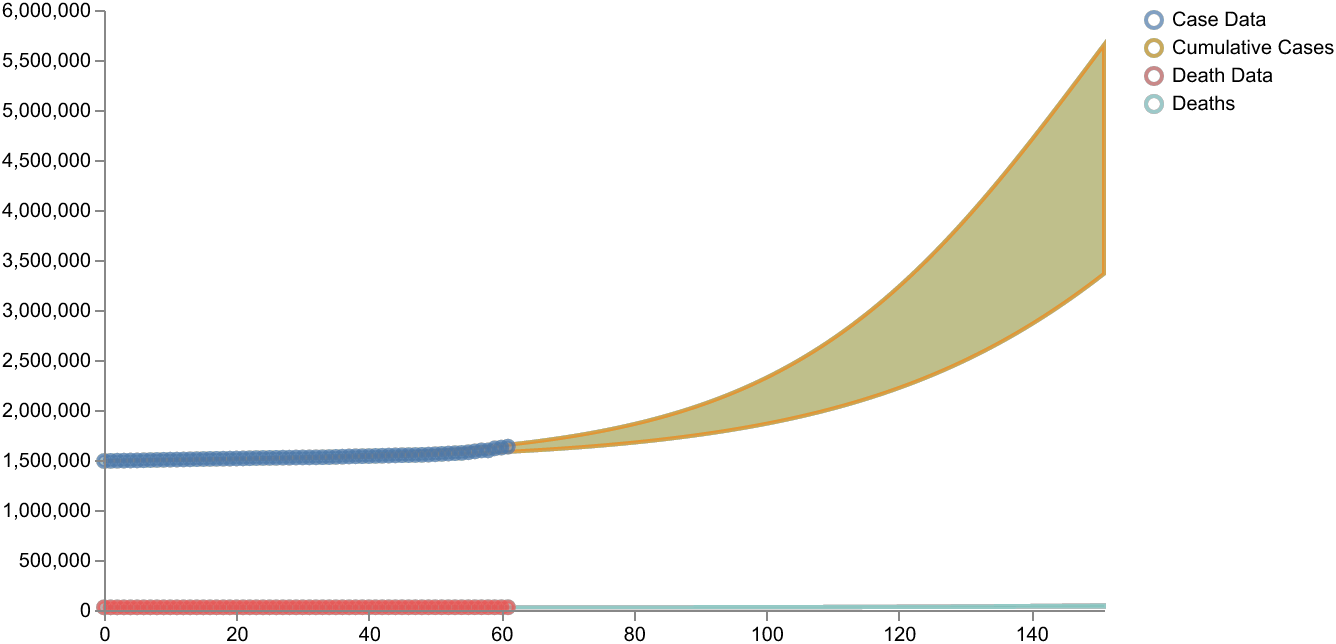

In [14]:
calibrated_sample_results = pyciemss.sample(
    model, 
    end_time, 
    logging_step_size, 
    num_samples,             
    start_time=start_time, 
    inferred_parameters=parameter_estimates
)
# display(calibrated_sample_results["data"].head())

# Plot the result
nice_labels = {
        "cumulative_cases_observable_state": "Cumulative Cases",
        "deceased_observable_state": "Deaths", 
        }
nice_data_names = {
        "cases": "Case Data",
        "deaths": "Death Data"
        }
data_df = pd.read_csv(data)
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(
    pd.DataFrame(calibrated_sample_results["data"]), 
    keep=["cumulative_cases_observable_state", "deceased_observable_state"], 
    relabel=nice_labels,
    points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
)

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Plot results for hospitalizations (Scenario 2 - Part II)

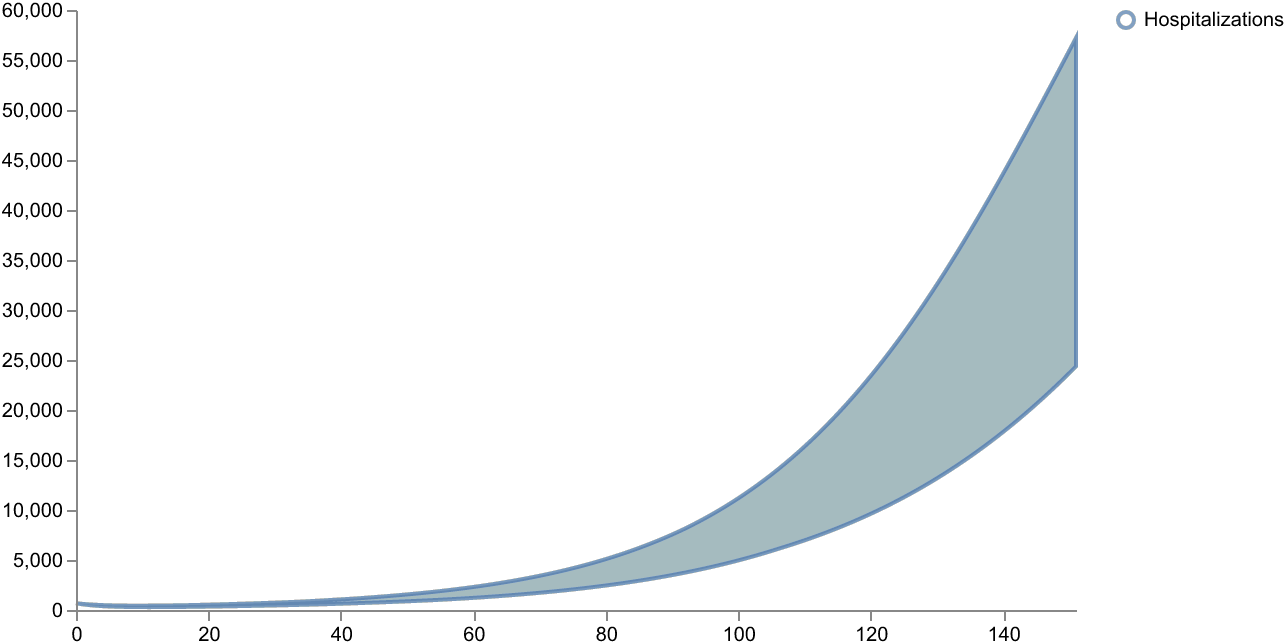

In [15]:
nice_labels = {
        "hospitalized_observable_state": "Hospitalizations", 
        }

schema = plots.trajectories(
    calibrated_sample_results["data"], 
    keep="hospitalized_observable_state",
    relabel=nice_labels
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

In [16]:
calibrated_sample_results["data"]["H_state"][61:80]

61    1940.481201
62    2013.105469
63    2088.561523
64    2166.955078
65    2248.396484
66    2332.998047
67    2420.877441
68    2512.156250
69    2606.958740
70    2705.416016
71    2807.658447
72    2913.830322
73    3024.067139
74    3138.518799
75    3257.337646
76    3380.678467
77    3508.702148
78    3641.580322
79    3779.478760
Name: H_state, dtype: float64

# Find optimal start time for intervention to reduce transmission by 50%

### Set up optimization and quantity of interest

In [17]:
num_samples_ouu = 100 # controls accuracy of risk estimation in each optimization iteration
maxiter = 3    # maximum number of restarts of local convex optimizer leading to maxiter+1 local optimizations
maxfeval = 30  # maximum number of function evaluations in each instance of local convex optimization

# Define QOI as maximum value over entire simulation
def obs_max_qoi(samples: Dict[str, torch.Tensor], contexts: List) -> np.ndarray:
    """
    Return maximum value over simulated time.
    samples is is the output from a Pyro Predictive object.
    samples[VARIABLE] is expected to have dimension (nreplicates, ntimepoints)
    """
    dataQoI = samples[contexts[0]].detach().numpy()
    return np.max(dataQoI, axis=1)

### Optimize intervention start time

Find the latest time (after 12/28/2021) an intervention which reduces transmission by 50% can be applied to keep hospitalizations below 3,000

In [18]:
# Define optimization problem setup
observed_params = ["H_state"]
intervened_params = ["NPI_mult"]
initial_guess_interventions = 61.0
bounds_interventions = [[61.0], [end_time]] # bounds within 12/28/2021 and end_time
intervention_value = torch.tensor([0.5])
static_parameter_interventions = start_time_objective(
    param_name = intervened_params,
    param_value = intervention_value,
)

risk_bound = 3000.0
qoi = lambda y: obs_max_qoi(y, observed_params)
objfun = lambda x: -x

# Run optimize interface
optimization_result = pyciemss.optimize(
    model,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    inferred_parameters=parameter_estimates,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
)

print(f'Optimal policy:', optimization_result["policy"])
print(optimization_result)
print("Intervention: ", static_parameter_interventions(optimization_result["policy"]))

  2%|▊                                               | 2/120 [00:06<05:45,  2.93s/it]/Users/altu809/Projects/pyciemss/pyciemss/ouu/ouu.py:108: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/altu809/Projects/pyciemss/pyciemss/ouu/ouu.py:108: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/altu809/Projects/pyciemss/pyciemss/ouu/ouu.py:108: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/altu809/Projects/pyciemss/pyciemss/ouu/ouu.py:108: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/altu809/Projects/pyciemss/pyciemss/ouu/ouu.py:108: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/altu809/Projects/pyciem

Optimal policy: tensor([27.3876], dtype=torch.float64)
{'policy': tensor([27.3876], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: False
                        fun: 109.5502877486178
                          x: [ 2.739e+01]
                        nit: 3
      minimization_failures: 4
                       nfev: 120
 lowest_optimization_result: message: Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
                             success: False
                              status: 4
                                 fun: 109.5502877486178
                                   x: [ 2.739e+01]
                                nfev: 30
                               maxcv: 3000.0}
Intervention:  {27.3876: {'NPI_mult': tensor(0.5000)}}



/Users/altu809/Projects/pyciemss/pyciemss/interfaces.py:959: UserWarning: Optimal intervention policy is out of bounds. Try (i) expanding the bounds_interventions and/or(ii) different initial_guess_interventions.
  warnings.warn(
/Users/altu809/Projects/pyciemss/pyciemss/interfaces.py:964: UserWarning: Optimal intervention policy does not satisfy constraints.Check if the risk_bounds value is appropriate for given problem.Otherwise, try (i) different initial_guess_interventions, (ii) increasing maxiter/maxfeval,and/or (iii) increase n_samples_ouu to improve accuracy of Monte Carlo risk estimation. 
  warnings.warn(


In [19]:
static_parameter_interventions(optimization_result["policy"])

{27.3876: {'NPI_mult': tensor(0.5000)}}

### Sample with intervention at optimal time

Risk associated with QoI: [11096.141406249999]


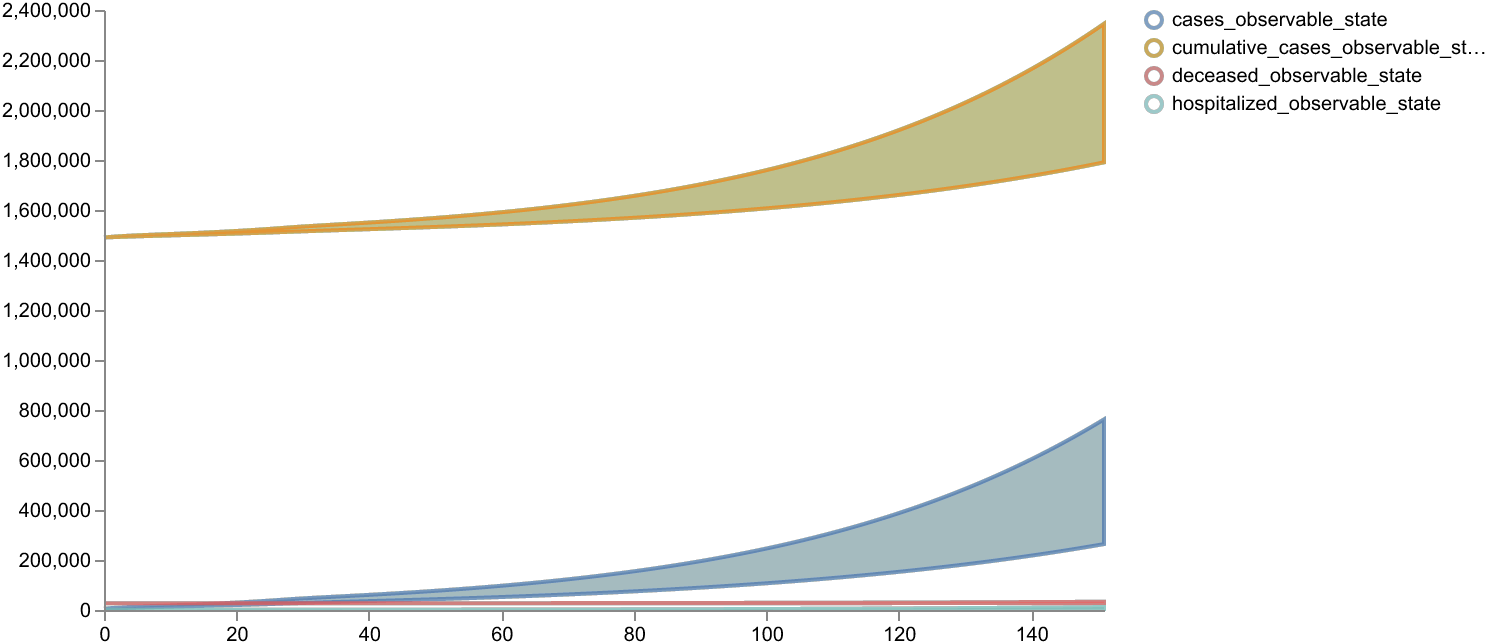

In [20]:
opt_intervention_result = pyciemss.sample(
    model,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    inferred_parameters=parameter_estimates,
    static_parameter_interventions=static_parameter_interventions(optimization_result["policy"]),
)

# Check risk estimate used in constraints
print("Risk associated with QoI:", opt_intervention_result["risk"][observed_params[0]]["risk"])

# Plot results for observables
schema = plots.trajectories(opt_intervention_result["data"], keep=".*observable_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

### Plot hospitalizations with optimal intervention applied

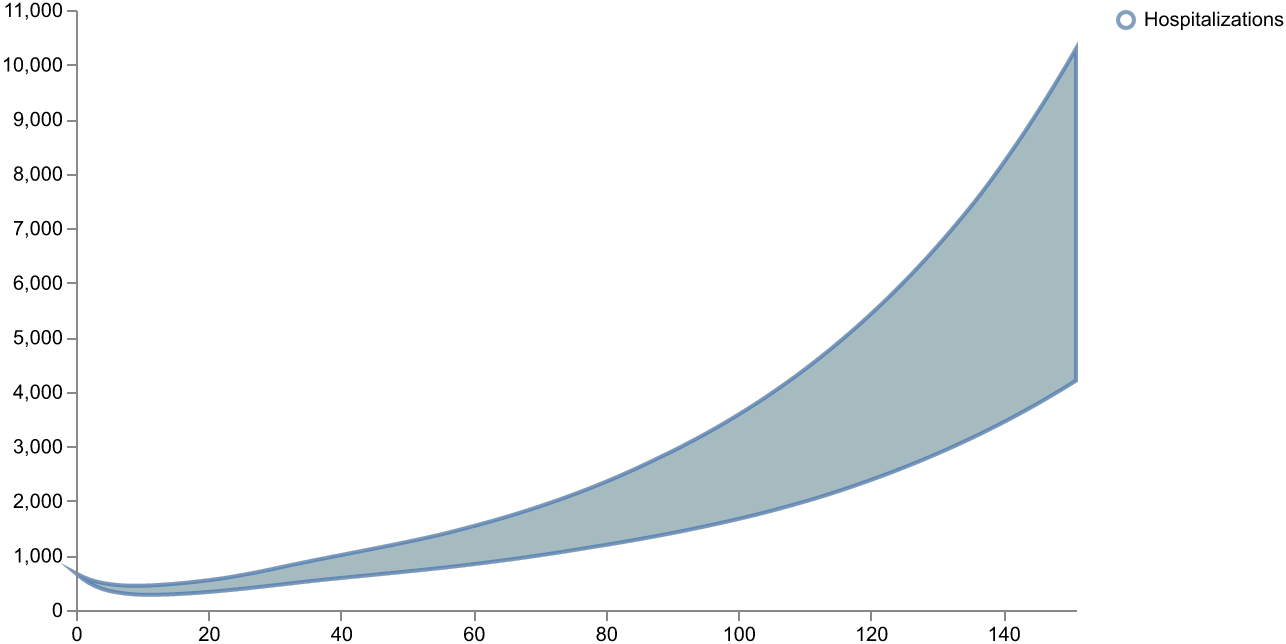

In [21]:
nice_labels = {
        "hospitalized_observable_state": "Hospitalizations", 
        }

schema = plots.trajectories(
    opt_intervention_result["data"], 
    keep="hospitalized_observable_state",
    relabel=nice_labels
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## TRY AGAIN: Optimize intervention start time

Previous attempt fails, cannot find a time after after 12/28/2021 when the intervention can be applied.

Find the latest time (after 12/17/2021, day 50) an intervention which reduces transmission by 98% can be applied to keep hospitalizations below 3,000

In [ ]:
# Define optimization problem setup
observed_params = ["H_state"]
intervened_params = ["NPI_mult"]
initial_guess_interventions = 52.0
bounds_interventions = [[51.0], [end_time]] # wider bounds within 12/17/2021 and end_time
intervention_value = torch.tensor([0.02])
static_parameter_interventions = start_time_objective(
    param_name = intervened_params,
    param_value = intervention_value,
)

risk_bound = 3000.0
qoi = lambda y: obs_max_qoi(y, observed_params)
objfun = lambda x: -x

# Run optimize interface
optimization_result = pyciemss.optimize(
    model,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    inferred_parameters=parameter_estimates,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
)

print(f'Optimal policy:', optimization_result["policy"])
print(optimization_result)
print("Intervention: ", static_parameter_interventions(optimization_result["policy"]))

### Sample with intervention at optimal time

In [ ]:
opt_intervention_result = pyciemss.sample(
    model,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    inferred_parameters=parameter_estimates,
    static_parameter_interventions=static_parameter_interventions(optimization_result["policy"]),
)

# Check risk estimate used in constraints
print("Risk associated with QoI:", opt_intervention_result["risk"][observed_params[0]]["risk"])

# Plot results for observables
schema = plots.trajectories(opt_intervention_result["data"], keep=".*observable_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

### Plot hospitalizations with optimal intervention applied

In [ ]:
nice_labels = {
        "hospitalized_observable_state": "Hospitalizations", 
        }

schema = plots.trajectories(
    opt_intervention_result["data"], 
    keep="hospitalized_observable_state",
    relabel=nice_labels
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)